**以驚嘆號!開頭表示與評分標準相關之說明**

### Steps:
* 1- Preprocessing and exploring
    * 1.1- Imports
    * 1.2 - Missing Values
    * 1.3 - Exploring
    * 1.4 - Feature Engineering
    * 1.5 - Prepare for models
* 2- Nested Cross Validation
* 3- Submission
    
   


## references
this work is based on:https://www.kaggle.com/code/goldens/titanic-on-the-top-with-a-simple-model/notebook  
the way deal with feature 'age' is base on:https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9  
the way deal with feature 'age' is base on: https://ithelp.ithome.com.tw/articles/10197461  
the way create overfitting module is base on: https://ithelp.ithome.com.tw/articles/10197461  
cross validation, GridSearchCV: http://www.taroballz.com/2018/07/10/ML_Model_Select_optimize/

## Screenshot at Kaggle
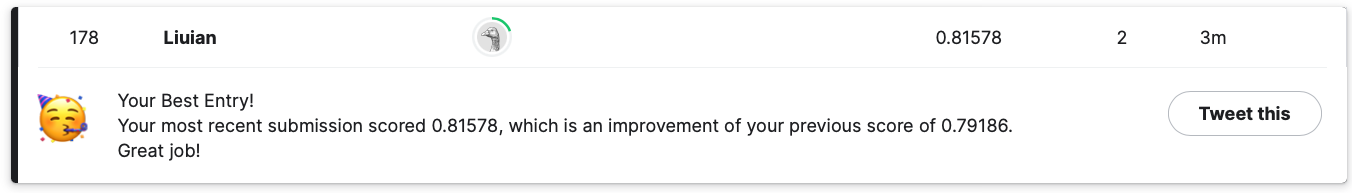  

**!(Bouns） 將最佳實驗結果套用到 test.Csv 並取得 Kaggle Public Leaderboard Top 1%**  
**!！準確度超越課堂範例（81%）**

## 1- Preprocessing and exploring

## 1.1 - Imports & observe

* import the packages  
* read the files:train.csv & test.csv  
* titanic: contact train.csv & test.csv  
* test2: test.csv  
* len_train: the length of the traning data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test2=pd.read_csv("test.csv")
titanic=pd.concat([train, test], sort=False)
len_train=train.shape[0]

#### observe
* observe the datatype with list and dataframe

In [3]:
titanic.dtypes.sort_values()

PassengerId      int64
Pclass           int64
SibSp            int64
Parch            int64
Survived       float64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [4]:
titanic.shape

(1309, 12)

In [5]:
titanic.select_dtypes(include='int').head()

,PassengerId,Pclass,SibSp,Parch
0,1,3,1,0
1,2,1,1,0
2,3,3,0,0
3,4,1,1,0
4,5,3,0,0


In [6]:
titanic.select_dtypes(include='object').head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [7]:
titanic.select_dtypes(include='float').head()

,Survived,Age,Fare
0,0.0,22.0,7.2500
1,1.0,38.0,71.2833
2,1.0,26.0,7.9250
3,1.0,35.0,53.1000
4,0.0,35.0,8.0500


## 1.2 - Missing values

In [8]:
titanic.isnull().sum()[titanic.isnull().sum()>0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

### Fare
**!處理缺失值**  
fill mean into the null place of fare. Because fare is a float value and there is only one missing value

In [9]:
train.Fare=train.Fare.fillna(train.Fare.mean())
test.Fare=test.Fare.fillna(train.Fare.mean())

### Cabin
**!處理缺失值**  
fill in "unknow" into Cabin's missing value,   
because there are too many missing value(missing 1014/1309)  
and also because it's datatype is object

In [10]:
train.Cabin=train.Cabin.fillna("unknow")
test.Cabin=test.Cabin.fillna("unknow")

### Embarked
**!處理缺失值**  
fill in 0 into Embarked missing value,  
because there are only 2 missing value

In [11]:
train.Embarked=train.Embarked.fillna(train.Embarked.mode()[0])
test.Embarked=test.Embarked.fillna(train.Embarked.mode()[0])

### Age
**!轉換數值資料**  
**!使用其他方法進行資料前處理:以分類取平均的方法處理age的缺失值**
* first, observe all the member's title by their name.  
* second, merge some titles and indicate one title to each person  
* third, seperate all people by their title and gender. Coculate the mean age of the people those have same title and gender.  
* lastely, fill in "age" in missing value  we just count.
Inspired on: https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9

In [12]:
# split the name and pick up the title, and store it as one training variable
train['title']=train.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
test['title']=test.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
train.head()

In [18]:
# observe the titles
pd.set_option('display.max_rows', None)
print(train.title.value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: title, dtype: int64


In [20]:
# merge some same titles into one category
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [21]:
# replace the titles
train['title']=train.title.map(newtitles)
test['title']=test.title.map(newtitles)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknow,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknow,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknow,S,Mr


In [22]:
# observe the relatiionship between title and sex
# and also the mean of their age
train.groupby(['title','Sex']).Age.mean()

title    Sex   
Master   male       4.574167
Miss     female    21.804054
Mr       male      32.368090
Mrs      female    35.718182
Officer  female    49.000000
         male      46.562500
Royalty  female    40.500000
         male      42.333333
Name: Age, dtype: float64

In [23]:
# fill in "age" in missing value  we just count
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male': 
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.50
        else:
            return 42.33
    else:
        return Age 

In [25]:
train.Age=train[['title','Sex','Age']].apply(newage, axis=1)
test.Age=test[['title','Sex','Age']].apply(newage, axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknow,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknow,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknow,S,Mr


### 1.3 - Exploring
**!以資料視覺化輔助資料分析**
* draw the barplot between variable 'survived', and other variable. Observe their relation ship.
* my insight
    * SibSp and Parch don't seem to have a clear relationship with the target, so put them together can be a good idea.
    * For Ticket and Cabin a good strategie can be count the number of caracteres.

<AxesSubplot:xlabel='Fare'>

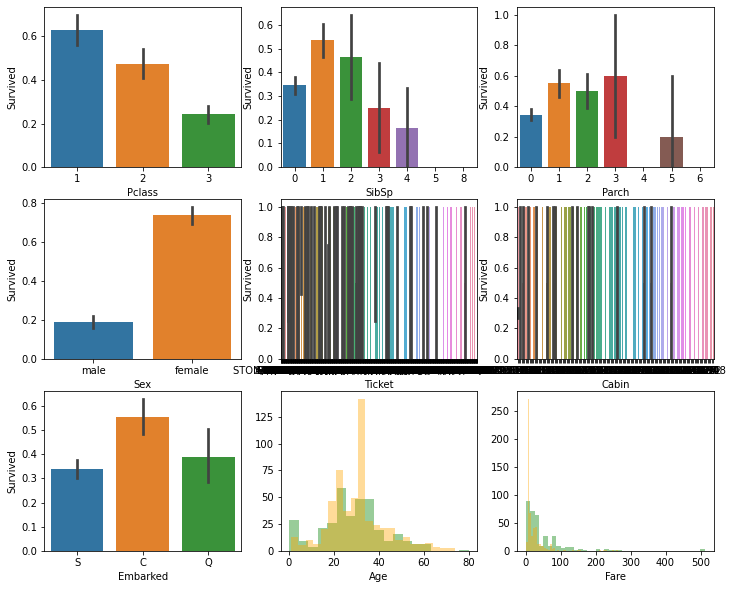

In [26]:
# 設定圖片的寬度為 12 英寸，高度為 10 英寸。
# 這個大圖中創建一個3x3的子圖
# 在對應的格子內話barplot
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Pclass','Survived',data=train)
plt.subplot(3,3,2)
sns.barplot('SibSp','Survived',data=train)
plt.subplot(3,3,3)
sns.barplot('Parch','Survived',data=train)
plt.subplot(3,3,4)
sns.barplot('Sex','Survived',data=train)
plt.subplot(3,3,5)
sns.barplot('Ticket','Survived',data=train)
plt.subplot(3,3,6)
sns.barplot('Cabin','Survived',data=train)
plt.subplot(3,3,7)
sns.barplot('Embarked','Survived',data=train)
plt.subplot(3,3,8)
sns.distplot(train[train.Survived==1].Age, color='green', kde=False)
sns.distplot(train[train.Survived==0].Age, color='orange', kde=False)
plt.subplot(3,3,9)
sns.distplot(train[train.Survived==1].Fare, color='green', kde=False)
sns.distplot(train[train.Survived==0].Fare, color='orange', kde=False)

### 1.4 Feature Engineering
**!使用其他方法進行資料前處理:將兩個feature合併**
* 根據上方觀察結果，講SibSp, Parch的值相加  
* Ticket2 定義為 Ticket 的字串長度  
* Cabin2 定義為 Cabin 的字串長度  
* Name2: 將 "train" 資料集中 "Name" 欄位的資料依照 "," 進行分割，並選取分割後第一個元素 (index = 0)，再去掉字串前後的空白字元 (strip())，最後將處理完的資料存到 "Name2" 欄位中。
* 將三個新的variable與'Survived' 畫出barplot再做一次觀察

In [28]:
# 根據上方觀察結果，講SibSp, Parch的值相加
train['Relatives']=train.SibSp+train.Parch
test['Relatives']=test.SibSp+test.Parch

# # Ticket2 定義為 Ticket 的字串長度
train['Ticket2']=train.Ticket.apply(lambda x : len(x))
test['Ticket2']=test.Ticket.apply(lambda x : len(x))

# Cabin2 定義為 Cabin 的字串長度
train['Cabin2']=train.Cabin.apply(lambda x : len(x))
test['Cabin2']=test.Cabin.apply(lambda x : len(x))

# 將 "train" 資料集中 "Name" 欄位的資料依照 "," 進行分割，並選取分割後第一個元素 (index = 0)，再去掉字串前後的空白字元 (strip())，最後將處理完的資料存到 "Name2" 欄位中。
train['Name2']=train.Name.apply(lambda x: x.split(',')[0].strip())
test['Name2']=test.Name.apply(lambda x: x.split(',')[0].strip())
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,Relatives,Ticket2,Cabin2,Name2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknow,S,Mr,1,9,6,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,8,3,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknow,S,Miss,0,16,6,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,6,4,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknow,S,Mr,0,6,6,Allen


<AxesSubplot:xlabel='Cabin2', ylabel='Survived'>

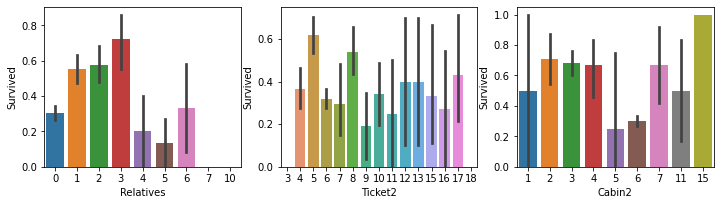

In [29]:
# 將三個新的variable與'Survived' 畫出barplot再做一次觀察
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Relatives','Survived',data=train)
plt.subplot(3,3,2)
sns.barplot('Ticket2','Survived',data=train)
plt.subplot(3,3,3)
sns.barplot('Cabin2','Survived',data=train)

### 1.4 - Prepare for model
* drop剛剛被合併過的features 及不相關的feature:PassengerID, Name  
* 合併tiain, test.  
* 做one-hot encoding **!轉換類別資料**  
* 將兩筆資料分開
* 將'Survived' datatype 改為int

In [30]:
#droping features I won't use in model
train.drop(['PassengerId','Name','Ticket','SibSp','Parch','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket','SibSp','Parch','Ticket','Cabin'],axis=1,inplace=True)

In [31]:
titanic=pd.concat([train, test], sort=False)

In [32]:
# split the categoriel based on their categorys
titanic=pd.get_dummies(titanic)
titanic.head()

,Survived,Pclass,Age,Fare,Relatives,Ticket2,Cabin2,Sex_female,Sex_male,Embarked_C,...,Name2_Zabour,Name2_Zakarian,Name2_Zimmerman,Name2_de Brito,Name2_de Messemaeker,Name2_de Mulder,Name2_de Pelsmaeker,Name2_del Carlo,Name2_van Billiard,Name2_van Melkebeke
0,0.0,3,22.0,7.2500,1,9,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,38.0,71.2833,1,8,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,0,16,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,35.0,53.1000,1,6,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,0,6,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train=titanic[:len_train]
test=titanic[len_train:]

In [34]:
# Lets change type of target
train.Survived=train.Survived.astype('int')
train.Survived.dtype

dtype('int64')

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Columns: 893 entries, Survived to Name2_van Melkebeke
dtypes: float64(2), int64(5), uint8(886)
memory usage: 826.6 KB


In [36]:
xtrain=train.drop("Survived",axis=1)
ytrain=train['Survived']
xtest=test.drop("Survived", axis=1)

# 2 - Nested Cross Validation
**!使用多個不同模型進行實驗**  
**!控制隨機亂數讓實驗結果可以重現**

### Random Forest
#### what is random Forest?   
**!使用 markdown 區塊簡單解釋模型演算法**  
Random Forest is a popular machine learning algorithm used for classification, regression and other tasks. It is an ensemble learning method that creates a large number of decision trees at training time and output the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Random Forest algorithm is called "random" because it uses a random subset of features for each decision tree. This makes the algorithm more robust to overfitting than using a single decision tree. Additionally, Random Forest allows to compute the feature importance, which indicates how much each feature contributes to the prediction task.  

**!使用 5-fold cross validation 輸出平均準確度**  
**!ensemble learning**

**!解釋模型超參數的選擇理由**
#### Why I choose to use GridSearchCV?
GridSearchCV tries all possible combinations and returns the best set of hyperparameters based on a specified performance metric, so that I don't need to manually try different combinations of hyperparameters.

In [46]:
# random_state 參數設定為 1，可以確保在每次執行隨機森林算法時使用同一個隨機種子，使得結果具有可重複性
RF=RandomForestClassifier(random_state=1)
# PRF 是一個參數網格 (parameter grid)。其中criterion是決策樹分裂節點的標準，可以是基尼係數 (gini) 或熵 (entropy)
PRF=[{'n_estimators':[10,100],'max_depth':[3,6],'criterion':['gini','entropy']}]
# GridSearchCV 物件是一個參數調整的工具，可以在指定的參數範圍內搜尋最佳的模型超參數。
# estimator 參數指定使用的模型，這裡是 RF，即隨機森林分類器。
# scoring 參數指定模型的評估指標，這裡是 accuracy，表示分類器的準確度。
# cv 參數指定交叉驗證的分割策略，這裡是5-flod交叉驗證。
GSRF=GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy',cv = 5)
# cross_val_score 是用來對一個估算器（estimator）進行交叉驗證（cross-validation）評分的函數，可以得到該模型在每次交叉驗證中的得分。cv = 5進行五次計算
scores_rf=cross_val_score(GSRF,xtrain,ytrain,scoring='accuracy',cv=5)

In [47]:
np.mean(scores_rf)

0.8002244668911335

In [48]:
scores_rf

array([0.77441077, 0.84511785, 0.78114478])

### SVM
#### What is SVM?  
**!使用 markdown 區塊簡單解釋模型演算法**  
Support Vector Machine (SVM) is a powerful machine learning algorithm used for classification and regression analysis. In SVM, the data is represented as points in space and the goal is to find the best possible boundary (or hyperplane) that can separate the points into different classes. This boundary is chosen so that it maximizes the margin between the two classes, which makes it more robust to new, unseen data. SVM can work well even with high-dimensional data and can handle non-linear relationships between the features by using kernel functions to map the data to a higher-dimensional space where it can be linearly separated.  
  
  **!使用決策樹以外的模型進行實驗**

In [49]:
svc=make_pipeline(StandardScaler(),SVC(random_state=1))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, xtrain.astype(float), ytrain,scoring='accuracy', cv=5)

In [50]:
np.mean(scores_svm)

0.8439645973259683

# 3 - Submission

In [51]:
model=GSSVM.fit(xtrain, ytrain)

In [55]:
model.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma=0.0001, random_state=1))])

In [52]:
pred=model.predict(xtest)

In [53]:
output=pd.DataFrame({'PassengerId':test2['PassengerId'],'Survived':pred})

In [54]:
output.to_csv('submission.csv', index=False)